# Driver Program Function

In [1]:
def find_drivers(df, target, estimator, num_top_features, tune_params = False, task = 'classification', 
                 binary_or_multiclass = 'binary', method = 'tree', big_data = True, plot = True, deterministic_output_w_coeffs = None):
    
    
    '''
    
    This program is meant to identify the top "drivers" or features that impact the target variable the most, on any dataset that is fed into it
    
    Arguments
    
    df: this is simply the df that you are using
    
    target: this is the target column, this needs to be entered with single quote marks around it (i.e. 'Feedback_RatingValue')
    
    estimator: estimator is the model that you want to use to run the analysis. Models that are supported by this program are Random Forests, LightGBM, CatBoost, OLS, Logistic
                Regression, and LinearSVC. These models must be specified by their abbreviations:
                
                - 'rf' == Random Forest
                
                - 'lgb' == LightGBM
                
                - 'cat' == CatBoost
                
                - 'ols' == OLS Regression
                
                - 'logit' == Logistic Regression
                
                - 'svc' == LinearSVC
                
    num_top_features: this argument accepts an integer value, it is simply the number of top features that you want to see from the dataset that you are using
    
    tune_params: this argument can be either -- True -- or -- None -- if it is set to True, then a gridsearch will be performed over a pre-determined set of hyperparameters
                    while if this argument is set to None then there will be no tuning of the model
    
    task: task can either be 'classification' or 'regression'
    
    binary_or_multiclass: this is only applicable for classification tasks and is either 'binary' or 'multiclass' -- really only there since we need to specify this explicitly
                                for LightGBM
    
    method: this argument is the method with which you would like to select the top features or drivers from your dataset. There are three different methods currently supported here.
            The first method is 'tree' and will use  Random Forest or LightGBM's built-in feature importances capabilities to extract the top features, 'tree' can only be used with 
            Random Forest or LightGBM, not CatBoost. 'cat' is the method that MUST be used when using a CatBoost model since it has a native implementation of feature importance 
            selection. Lastly, 'select_from_model' is a method that is used with the Random Forest and LightGBM that will select the top n features from your dataset
            
    big_data: this arg can be either -- True or None -- when set to True the program will use the tree-based models for feature extraction, when set to None the program
                will use OLS Regression, Logistic Regression, or LinearSVC and then use RFE for feature extraction, this is meant to be done for smaller datasets or if you 
                need a more deterministic output, i.e. regression coefficients 
    
    
    plot: This last argument is simply set to True by default and calls plotly to create a bar plot of the feature importances in your dataset
    
    deterministic_output_w_coeffs: this arg will allow you to return a single df that contains the coefficients and statsig values for each variable in the model, this is in 
                                    case you are more interested in just running a logistic regression on the data for some reason, its just an extra treat
    
    
    
    Output
    
    The output of this program varies based on what you are running. If you are running a tree-based model with a feature selection method that is not 
    select_from_model, then you need to unpack the output in the following manner: a, b = find_drivers() ------- the 'a' will be a df of the feature importances
    while the 'b' will be your original df subset by the important features. If you use select_from_model then the output will only be singular and it will be a 
    df that has been truncated to the number of features you wanted, so you would use it this way: a = find_drivers() ------- As far as the output of the models
    for smaller datasets, Recursive Feature Elimination will rank the features and the output will be a df of these ranks, so again you only need to use one 
    variable to call the program: a = find_drivers() ---- 
    
    
    '''
    
    
    
    import pandas as pd
    
    import numpy as np
    
    
    #edge case handling
    if df.shape[0] == 0:
        
        raise ValueError("You have given me a blank dataframe! This ain't gonna work")
        
    elif (estimator == 'cat') & (method != 'cat'):
        
        raise ValueError("CatBoost model can only be used with 'cat' method of feature selection")
        
    elif (method == 'select_from_model') & (plot is not None):
        
        raise ValueError("Sorry, you can't plot feature importances when using the 'SelectFromModel' method, change to: plot = False")
        
    elif (estimator in ['rf', 'lgb', 'cat']) & (big_data is None):
        
        raise ValueError("You cannot use tree-based models when 'big_data' is set to None")
        
    elif (estimator in ['ols', 'logit', 'svc']) & (big_data is not None):
        
        raise ValueError('Ouch! This model is not supported for big data, use an ensemble or boosting model instead')
        
    elif (estimator in ['ols']) & (task == 'classification'):
        
        raise ValueError('You cannot use OLS Regression for classification')
        
    elif (estimator in ['ols', 'logit', 'svc']) & (tune_params is not None):
        
        raise ValueError('Hyperparameter tuning is not supported for this model, it is only supported for tree-based models on larger datasets')
        
    elif estimator not in ['rf', 'lgb', 'cat', 'logit', 'svc', 'ols']:
        
        raise ValueError('The model that you picked is not supported by this program')
        
    elif binary_or_multiclass not in ['binary', 'multiclass']:
        
        raise ValueError("'binary_or_multiclass must be either 'binary' or 'multiclass'")
        
    elif method not in ['tree', 'select_from_model', 'cat']:
        
        raise ValueError("method must be one of 'tree', 'select_from_model', or 'cat'")
        
        
    
    #specify features and target up front
    features = df.drop(target, axis = 1)
    
    target = df[target]
    
    
    
    if df.shape[0] < 10000:
        
        print('Hi! Your data set is kinda tiny, consider using Logistic Regresssion with Recursive Feature Selection')
        
    else:
        
        print("Hi! Your dataset is large, you should probably use a tree-based model if you aren't already")
        
    
    
    
    
    #need to talk to Erfan about what would be an appropriate size here
    if big_data is not None:
        
        if tune_params is not None:
            
            from sklearn.model_selection import RandomizedSearchCV
            
            #set up param grid for gridsearches
            param_grid =  {'n_estimators':[200, 400, 600, 800, 1000, 1500], 'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, None]}
            
            #set up grid for catboost
            cat_param_grid = {'depth':[4, 5, 6, 7, 8, 9, 10]}
            
            print('Beginning Driver Analysis')
            
            if estimator == 'rf':
                
                print('Random Forest Model Selected')
            
                if task == 'classification':
                    
                    print('Beginning Random Forest Classification')
                    
                    from sklearn.ensemble import RandomForestClassifier
        
                    model = RandomForestClassifier(random_state = 0).fit(features, target)
                    
                    print('Tuning Random Forest Classifier')
                    
                    #start tuning model here with gridsearch
                    cv_model = RandomizedSearchCV(estimator = model, n_jobs = -1, 
                            param_distributions = param_grid, verbose = 10, scoring = 'neg_log_loss',
                            cv = 5).fit(features, target)
                    
                    #grab best values found in gridsearch
                    n_estimators, max_depth = cv_model.best_params_.values()
                    
                    print('Tuned Random Forest Classifier Model')
                    
                    #create second model
                    tuned_model = RandomForestClassifier(random_state = 42, n_estimators = n_estimators, max_depth = max_depth).fit(features, target)
            
                elif task == 'regression':
                    
                    print('Beginning Random Forest Regression')
                    
                    from sklearn.ensemble import RandomForestRegressor
                
                    model = RandomForestRegressor(random_state = 0).fit(features, target)
                    
                    print('Tuning Random Forest Regression Model')
                    
                    #start tuning regression model
                    cv_model = RandomizedSearchCV(estimator = model, n_jobs = -1, 
                        param_distributions = param_grid, verbose = 10, scoring = 'neg_root_mean_squared_error',
                        cv = 5).fit(features, target)
                    
                    #grab best values found in gridsearch
                    n_estimators, max_depth = cv_model.best_params_.values()
                    
                    print('Tuned Random Forest Regression Model')
                    
                    #create second model
                    tuned_model = RandomForestRegressor(random_state = 42, n_estimators = n_estimators, max_depth = max_depth).fit(features, target)
                
        
            elif estimator == 'lgb':
                
                print('Light Gradient Boosting Model Selected')
                
                import lightgbm as lgb
            
                if task == 'classification':
                    
                    print('Beginning LightGBM Classification')
                    
                    if binary_or_multiclass == 'binary':
                        
                        print('Binary Classification Selected')
            
                        model = lgb.LGBMClassifier(random_state = 0, objective = 'binary').fit(features, target)
                
                        print('Tuning Binary LightGBM Classification Model')
                    
                        #start tuning regression model
                        cv_model = RandomizedSearchCV(estimator = model, n_jobs = -1, 
                            param_distributions = param_grid, verbose = 10, scoring = 'neg_root_mean_squared_error',
                            cv = 5).fit(features, target)
                    
                        #grab best values found in gridsearch
                        n_estimators, max_depth = cv_model.best_params_.values()
                    
                        print('Tuned LightGBM Binary Classification Model')
                    
                        #create second model
                        tuned_model = lgb.LGBMClassifier(random_state = 42, n_estimators = n_estimators, max_depth = max_depth, objective = 'binary').fit(features, target)
                
                    elif binary_or_multiclass == 'multiclass':
                        
                        print('Multiclass Classification Selected')
                        
                        model = lgb.LGBMClassifier(random_state = 0, objective = 'multiclass').fit(features, target)
                        
                        print('Tuning Multiclass LightGBM Model')
                        
                        #start tuning model
                        cv_model = RandomizedSearchCV(estimator = model, n_jobs = -1, 
                            param_distributions = param_grid, verbose = 10, scoring = 'neg_root_mean_squared_error',
                            cv = 5).fit(features, target)
                    
                        #grab best values found in gridsearch
                        n_estimators, max_depth = cv_model.best_params_.values()
                    
                        print('Tuned LightGBM Multiclass Classification Model')
                    
                        #create second model
                        tuned_model = lgb.LGBMClassifier(random_state = 42, n_estimators = n_estimators, max_depth = max_depth, objective = 'multiclass').fit(features, target)
                
                elif task == 'regression':
                    
                    print('Beginning LightGBM Regression')
                
                    model = lgb.LGBMRegressor(random_state = 0).fit(features, target)
                    
                    print('Tuning LightGBM Regression Model')
                    
                    #start tuning regression model
                    cv_model = RandomizedSearchCV(estimator = model, n_jobs = -1, 
                            param_distributions = param_grid, verbose = 10, scoring = 'neg_root_mean_squared_error',
                            cv = 5).fit(features, target)
                    
                    #grab best values found in gridsearch
                    n_estimators, max_depth = cv_model.best_params_.values()
                    
                    print('Tuned LightGBM Regression Model')
                    
                    #create second model
                    tuned_model = lgb.LGBMRegressor(random_state = 42, n_estimators = n_estimators, max_depth = max_depth).fit(features, target)    
                    
            elif estimator == 'cat':
            
                print('CatBoost Model Selected')
            
                if task == 'classification':
                
                    print('Beginning CatBoost Classification')
                
                    from catboost import CatBoostClassifier, EFstrType
            
                    model = CatBoostClassifier(iterations = 2, loss_function = 'Logloss')
                
                    print('Tuning CatBoost Classification Model')
                    
                    #gotta use catboost's built in random search
                    randomized_search_result = model.randomized_search(cat_param_grid, X = features, y = target, plot = True)
                    
                    print('Tuned CatBoost Classification Model')
                    
                    #subset dict for depth - this fills in depth with the best value found in our search
                    tuned_model = CatBoostClassifier(iterations = 2, depth = randomized_search_result['params']['depth'], loss_function = 'Logloss').fit(features, target)
                
                elif task == 'regression':
                
                    print('Beginning CatBoost Regression')
                
                    from catboost import CatBoostRegressor, EFstrType
                
                    model = CatBoostRegressor(iterations = 2, loss_function = 'RMSE').fit(features, target)
                    
                    print('Tuning CatBoost Regression Model')
                    
                    #gotta use catboost's built in random search
                    randomized_search_result = model.randomized_search(cat_param_grid, X = features, y = target, plot = True)
                    
                    print('Tuned CatBoost Regression Model')
                    
                    tuned_model = CatBoostRegressor(iterations = 2, depth = randomized_search_result['params']['depth'], loss_function = 'RMSE').fit(features, target)
                    
            if method == 'tree':
                
                print('Beginning Feature Selection Using Built-In Tree Model Feature Importances')
                
                #getting feature importances
                learners = tuned_model.feature_importances_.argsort()[::-1]
                
                #turning them into a df
                features_df = pd.DataFrame(features.columns[learners], tuned_model.feature_importances_[learners])
                
                #get top 10 features from feature importances to be fed into the next model
                feature_importances = pd.DataFrame(features_df.iloc[:num_top_features, :]).reset_index().rename(columns = {'index':'importance', 0:'feature'})
                
                top_feats = [x for x in feature_importances.iloc[:, 1]]
                
                features = features[top_feats]
                
                #create final df
                final_df = pd.concat([features, target], axis = 1)
                
                #now that we know the top 10, we can fit another model on only these and get their unique contributions controlling for each other
                model = model.fit(features, target)
                
                learners = model.feature_importances_.argsort()[::-1]
                
                features_df = pd.DataFrame(features.columns[learners], model.feature_importances_[learners])
                
                #get top 10 features from feature importances to be fed into the next model
                feature_importances = pd.DataFrame(features_df.iloc[:num_top_features, :]).reset_index().rename(columns = {'index':'Importance', 0:'Feature'})
                
                #if we set this argument to True (it is by default) then the program will plot the importances
                if plot is not None:
                    
                    import plotly.express as px
                    
                    fig = px.bar(feature_importances, x="Importance", y="Feature", orientation='h', title = 'Feature Importances (Larger Bar = More Important)',
                                width = 1000, height = 600)
                    
                    fig.show()
                
                #return the feature importances and the subset features
                return feature_importances, final_df
            
            elif method == 'select_from_model':
                
                #NOTE: Using this method will not result in the ability for you to plot which features are 'more' important than the others, like the other two methods will
                
                print("Beginning 'Select From Model' Feature Selection")
                
                from sklearn.feature_selection import SelectFromModel
                
                #instantiate the feature selection model
                feature_selection_model = SelectFromModel(tuned_model, max_features = num_top_features, threshold = -np.inf, prefit = True)
                
                #get feature index
                feature_idx = feature_selection_model.get_support()
                
                #get feature names
                features_to_keep = features.columns[feature_idx]
                
                #drop features that were not selected
                columns_to_drop = []
                for x in features.columns:
                    if x not in features_to_keep:
                        columns_to_drop.append(x)
                        
                #drop the columns not selected by the feature selector
                features.drop(columns_to_drop, axis = 1, inplace = True)
                
                #create final df
                final_df = pd.concat([features, target], axis = 1)
                
                return final_df
            
            elif method == 'cat':
                
                print('Beginning Feature Selection Using CatBoost')
                
                #get names of top n features 
                top_feats = tuned_model.get_feature_importance(data=None, type=EFstrType.FeatureImportance, 
                                                                          prettified=True, thread_count=-1,verbose=False).iloc[:num_top_features, :]
                
                top_features = [x for x in top_feats.iloc[:,0]]
                
                #now we are going to subset the features for the n most important 
                features = features[top_features]
                
                #create final df
                final_df = pd.concat([features, target], axis = 1)
                
                #use reduced df to find each unique driver's contribution to the model controlling for the others
                model.fit(features, target)
                
                #Now this is what we want 
                top_feats = tuned_model.get_feature_importance(data=None, type=EFstrType.FeatureImportance, 
                                                                          prettified=True, thread_count=-1,verbose=False).iloc[:num_top_features, :]
                
                #if we set this argument to True (it is by default) then the program will plot the importances
                if plot is not None:
                    
                    import plotly.express as px
                    
                    fig = px.bar(top_feats, x="Importances", y="Feature Id", orientation='h', title = 'Feature Importances (Larger Bar = More Important)', 
                                width = 1000, height = 600)
                    
                    fig.show()
                
                #return the feature importances as well as the features subset
                return top_feats, final_df
        
        
        #this will execute if the user does not wish to tune hyperparameters AND if the dataset is over a certain amount of rows
        elif tune_params is None:
            
            if estimator == 'rf':
                
                print('Random Forest Model Selected')
            
                if task == 'classification':
                    
                    print('Beginning Random Forest Classification')
                    
                    from sklearn.ensemble import RandomForestClassifier
        
                    model = RandomForestClassifier(random_state = 0).fit(features, target)
            
                elif task == 'regression':
                    
                    print('Beginning Random Forest Regression')
                    
                    from sklearn.ensemble import RandomForestRegressor
                
                    model = RandomForestRegressor(random_state = 0).fit(features, target)
                    
            elif estimator == 'lgb':
                
                print('Light Gradient Boosting Model Selected')
                
                import lightgbm as lgb
            
                if task == 'classification':
                    
                    print('Beginning LightGBM Classification')
                    
                    if binary_or_multiclass == 'binary':
                        
                        print('Binary Classification Selected')
            
                        model = lgb.LGBMClassifier(random_state = 0, objective = 'binary').fit(features, target)  
                    
                    elif binary_or_multiclass == 'multiclass':
                        
                        print('Multiclass Classification Selected')
                        
                        model = lgb.LGBMClassifier(random_state = 0, objective = 'multiclass').fit(features, target)
                        
                elif task == 'regression':
                    
                    print('Beginning LightGBM Regression')
                
                    model = lgb.LGBMRegressor(random_state = 0).fit(features, target) 
                    
                
            elif estimator == 'cat':
            
                print('CatBoost Model Selected')
            
                if task == 'classification':
                
                    print('Beginning CatBoost Classification')
                
                    from catboost import CatBoostClassifier, EFstrType
            
                    model = CatBoostClassifier(iterations = 2, loss_function = 'Logloss').fit(features, target)
                
                elif task == 'regression':
                
                    print('Beginning CatBoost Regression')
                
                    from catboost import CatBoostRegressor, EFstrType
                
                    model = CatBoostRegressor(iterations = 2, loss_function = 'RMSE').fit(features, target)
                    
            if method == 'tree':
                
                print('Beginning Feature Selection Using Built-In Tree Model Feature Importances')
                
                #getting feature importances
                learners = model.feature_importances_.argsort()[::-1]
                
                #turning them into a df
                features_df = pd.DataFrame(features.columns[learners], model.feature_importances_[learners])
                
                #get top 10 features from feature importances to be fed into the next model
                feature_importances = pd.DataFrame(features_df.iloc[:num_top_features, :]).reset_index().rename(columns = {'index':'importance', 0:'feature'})
                
                top_feats = [x for x in feature_importances.iloc[:, 1]]
                
                features = features[top_feats]
                
                #create final df
                final_df = pd.concat([features, target], axis = 1)
                
                #now that we know the top 10, we can fit another model on only these and get their unique contributions controlling for each other
                model = model.fit(features, target)
                
                learners = model.feature_importances_.argsort()[::-1]
                
                features_df = pd.DataFrame(features.columns[learners], model.feature_importances_[learners])
                
                #get top 10 features from feature importances to be fed into the next model
                feature_importances = pd.DataFrame(features_df.iloc[:num_top_features, :]).reset_index().rename(columns = {'index':'Importance', 0:'Feature'})
                
                #if we set this argument to True (it is by default) then the program will plot the importances
                if plot is not None:
                    
                    import plotly.express as px
                    
                    fig = px.bar(feature_importances, x="Importance", y="Feature", orientation='h', title = 'Feature Importances (Larger Bar = More Important)',
                                width = 1000, height = 600)
                    
                    fig.show()
                
                #return both the feature importances and the subset features
                return feature_importances, final_df
            
            elif method == 'select_from_model':
                
                #NOTE: Using this method will not result in the ability for you to plot which features are 'more' important than the others, like the other two methods will
                
                print("Beginning 'Select From Model' Feature Selection")
                
                from sklearn.feature_selection import SelectFromModel
                
                #instantiate the feature selection model
                feature_selection_model = SelectFromModel(model, max_features = num_top_features, threshold = -np.inf, prefit = True)
                
                #get feature index
                feature_idx = feature_selection_model.get_support()
                
                #get feature names
                features_to_keep = features.columns[feature_idx]
                
                #drop features that were not selected
                columns_to_drop = []
                for x in features.columns:
                    if x not in features_to_keep:
                        columns_to_drop.append(x)
                        
                #drop the columns not selected by the feature selector
                features.drop(columns_to_drop, axis = 1, inplace = True)
                
                #create final df
                final_df = pd.concat([features, target], axis = 1)
                
                return final_df
            
            elif method == 'cat':
                
                from catboost import CatBoostRegressor, EFstrType
                
                print('Beginning Feature Selection Using CatBoost')
                
                #get names of top n features 
                top_feats = model.get_feature_importance(data=None, type=EFstrType.FeatureImportance, 
                                                                          prettified=True, thread_count=-1,verbose=False).iloc[:num_top_features, :]
                
                top_features = [x for x in top_feats.iloc[:,0]]
                
                #now we are going to subset the features for the n most important 
                features = features[top_features]
                
                #create final df
                final_df = pd.concat([features, target], axis = 1)
                
                #now have to use the trimmed feature set
                model = model.fit(features, target)
                
                #get top features for only these 10 features
                top_feats = model.get_feature_importance(data = None, type=EFstrType.FeatureImportance, 
                                                                          prettified=True, thread_count=-1,verbose=False).iloc[:num_top_features, :]
                
                #if we set this argument to True (it is by default) then the program will plot the importances
                if plot is not None:
                    
                    import plotly.express as px
                    
                    fig = px.bar(top_feats, x="Importances", y="Feature Id", orientation='h', title = 'Feature Importances (Larger Bar = More Important)', 
                                width = 1000, height = 600)
                    
                    fig.show()
                
                #return both the importances and the features set subset
                return top_feats, final_df
            
    elif big_data is None:
        
        print('Dealing With A Smaller Dataset, Utilizing Linear Methods')
        
        if task == 'classification':
            
            if estimator == 'logit':
                
                print('Beginning Logistic Regression Classification')
                
                from sklearn.preprocessing import StandardScaler
                from sklearn.linear_model import LogisticRegression
        
                #scale the data
                scaler = StandardScaler()
                
                scaled_features = scaler.fit_transform(features)
                
                model = LogisticRegression(random_state=0).fit(features, target)
                
                if deterministic_output_w_coeffs is not None:
                
                    #instead of seeing feature importance, you can see a table of coefficients
                    model = sm.Logit(target, scaled_features, iterations = 1000)

                    model = model.fit(method = 'bfgs')
            
                    results_summary = model.summary()
            
                    #create df from results
                    results_as_html = results_summary.tables[1].as_html()
                    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
                
                    #put names of features beside their coefs
                    results_df.index = [x for x in features.columns]
        
                    return results_df
            
            elif estimator == 'svc':
                
                print('Beginning Linear SVC Classification')
                
                from sklearn.svm import LinearSVC
                from sklearn.pipeline import make_pipeline
                from sklearn.preprocessing import StandardScaler
                
                scaler = StandardScaler()
                
                scaled_features = scaler.fit_transform(features)
                
                model = LinearSVC(random_state=0, tol=1e-5).fit(scaled_features, target)
                
        elif task == 'regression':
            
            #ols will be the only linear regression model supported
            if estimator == 'ols':
                
                print('Beginning OLS Regression')
                
                from sklearn.preprocessing import StandardScaler
                from sklearn.linear_model import LinearRegression
                
                scaler = StandardScaler()
                
                scaled_features = scaler.fit_transform(features)
            
                model = LinearRegression()
                
                model.fit(scaled_features, target)
            
    
        #will be performing RFE on all datasets this small
        from sklearn.feature_selection import RFE
    
        print('Beginning Recursive Feature Selection')
        
        selector = RFE(model, n_features_to_select = num_top_features, step = 1)
        
        selector = selector.fit(scaled_features, target)
            
        ranks = selector.ranking_
            
        columns = [c for c in features.columns]
            
        rank_df = pd.DataFrame(zip(columns, ranks)).rename(columns = {0:'Feature', 1:'Rank'})
    
        print('Driver Analysis Complete')
    
        #returns rank of features
        return rank_df

# Testing
- I have run this through a bunch of tests and it seems to be working well as of right now

In [55]:
#find drivers for outlook windows as a whole, without breaking it down into consumer, commercial
outlook_windows = driver_analysis.read_entire_csv('C:\\Users\\fulto\\Desktop\\Driver Analysis\\Teams', 'Teams_Web_and_Windows.csv')

shape before deleting missing columns: (65049, 321)
shape after deleting missing columns: (65049, 233)


In [56]:
#use code for outlook driver analysis to get sample df
mapper = {-100:0, 0:0, 100:1}

outlook_windows['Feedback_RatingValue'] = outlook_windows['Feedback_RatingValue'].map(mapper)

features_df = outlook_windows.fillna(0)
# target = features_df['Feedback_RatingValue']
# features = features_df.drop('Feedback_RatingValue', axis = 1)

#Label Encoding
for x in features_df.columns[features_df.dtypes == 'object']:
    features_df[x] = features_df[x].factorize()[0]

sample_df = features_df.iloc[:10500, :]

Hi! Your dataset is large, you should probably use a tree-based model if you are't already
Beginning Driver Analysis
Light Gradient Boosting Model Selected
Beginning LightGBM Classification
Binary Classification Selected
Tuning Binary LightGBM Classification Model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   40.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   46.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.6s finished


Tuned LightGBM Binary Classification Model
Beginning Feature Selection Using Built-In Tree Model Feature Importances


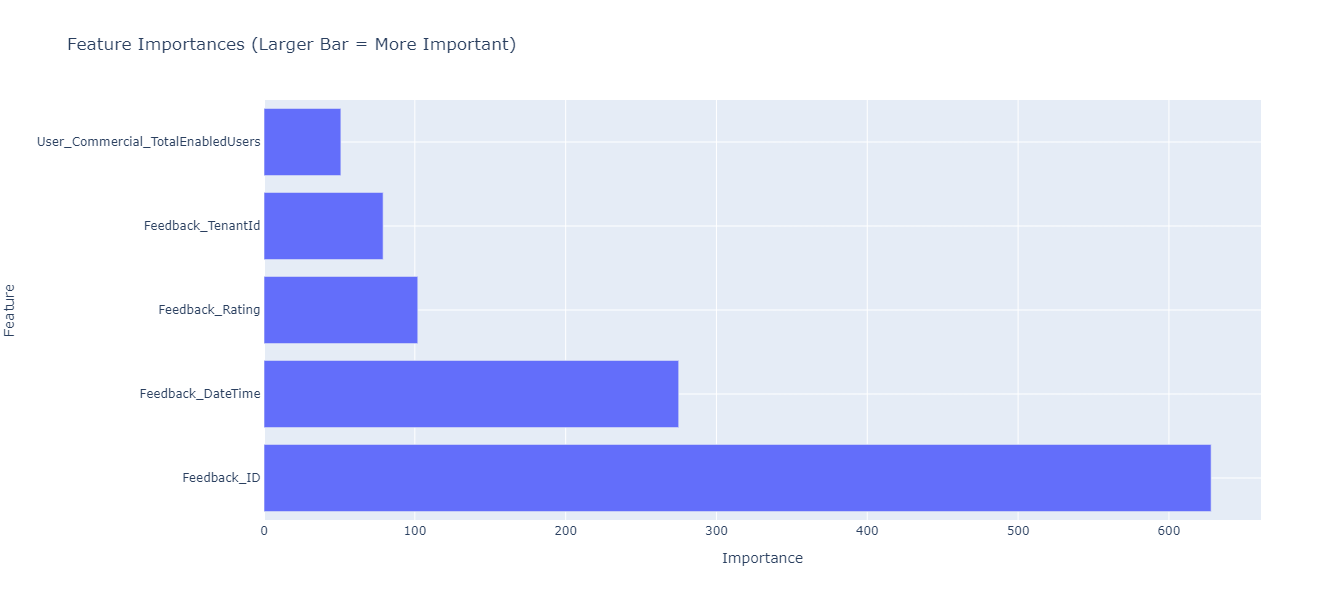

In [60]:
a, b = find_drivers(sample_df, 'Feedback_RatingValue', 'lgb', num_top_features = 5, tune_params = True, 
                 task = 'classification', binary_or_multiclass = 'binary', method = 'tree', big_data = True, plot = True)

In [45]:
a

,Importance,Feature
0,0,Tenant_HasQuickStart
1,0,Tenant_HasExchange
2,0,Tenant_HasLync
3,0,Tenant_HasYammer
4,0,Device_OsCodeName


In [46]:
b.head()

,Device_OsCodeName,Tenant_HasYammer,Tenant_HasLync,Tenant_HasExchange,Tenant_HasQuickStart,Feedback_RatingValue
0,0,1.0,1.0,1.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0
4,2,1.0,1.0,1.0,0.0,0.0
